In [1]:
from pathlib import Path

import numpy as np
from ase.io import read
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.base.leads import LeadSelfEnergy
from qtpyt.basis import Basis
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import expand_coupling, remove_pbc
import matplotlib.pyplot as plt

In [2]:
pl_path = Path('../dft/leads/')
cc_path = Path('../dft/device/')

h_pl_k, s_pl_k = np.load(pl_path/'hs_pl_k.npy')
h_cc_k, s_cc_k = map(lambda m: m.astype(complex), np.load(cc_path/'hs_cc_k.npy'))

# No. basis functions per atom kind
basis = {'Au':6,'C':4,'O':4}

atoms_pl = read(pl_path/'leads.xyz')
basis_pl = Basis.from_dictionary(atoms_pl, basis)

atoms_cc = read(cc_path/'scatt.xyz')
basis_cc = Basis.from_dictionary(atoms_cc, basis)

In [3]:
# (5,1,1) k-pts as in DFT leads
# (0,h_cc_k[0,0,0]) align 1st basis in leads and scattering region
kpts_t, h_pl_ii, s_pl_ii, h_pl_ij, s_pl_ij = map(lambda m: m[0], prepare_leads_matrices(h_pl_k, s_pl_k, (5,1,1), align=(0,h_cc_k[0,0,0])))
remove_pbc(basis_cc, h_cc_k)
remove_pbc(basis_cc, s_cc_k)


In [4]:
h_cc_k[0,0,0]

(-0.4351075044198538+0j)

In [5]:
print(kpts_t)
print(h_pl_ii.shape)
print(h_pl_ij.shape)

[0. 0. 0.]
(18, 18)
(18, 18)


In [5]:
se = [None, None]
se[0] = LeadSelfEnergy((h_pl_ii, s_pl_ii), (h_pl_ij, s_pl_ij)) # left lead
se[1] = LeadSelfEnergy((h_pl_ii, s_pl_ii), (h_pl_ij, s_pl_ij), id='right') # right lead
se[0].shape

(18, 18)

In [6]:
# expand to dimension of scattering
expand_coupling(se[0], len(h_cc_k[0]))
expand_coupling(se[1], len(h_cc_k[0]), id='right')
print(len(h_cc_k[0]))
print(h_cc_k.shape)
print(se[0].shape)


62
(1, 62, 62)
(62, 62)


In [9]:
h_cc_k.shape

(1, 62, 62)

In [8]:
de = 0.01
energies = np.arange(-4.,4.+de/2.,de).round(7)
eta = 1e-5

# slice(None) means that we've already expanded the leads to the scattering region
gf = GreenFunction(h_cc_k[0], s_cc_k[0], selfenergies=[(slice(None),se[0]),(slice(None),se[1])], eta=eta)

gd = GridDesc(energies, 1)
T = np.empty(gd.energies.size)

for e, energy in enumerate(gd.energies):
    T[e] = gf.get_transmission(energy)

T = gd.gather_energies(T)
if comm.rank == 0:
    np.save(f'ET', (energies, T))

(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (18, 18)
(18, 18) (18, 18) (18, 18) (

KeyboardInterrupt: 

In [ ]:
gf.H.shape

(62, 62)

Text(0, 0.5, '$T(E)$')

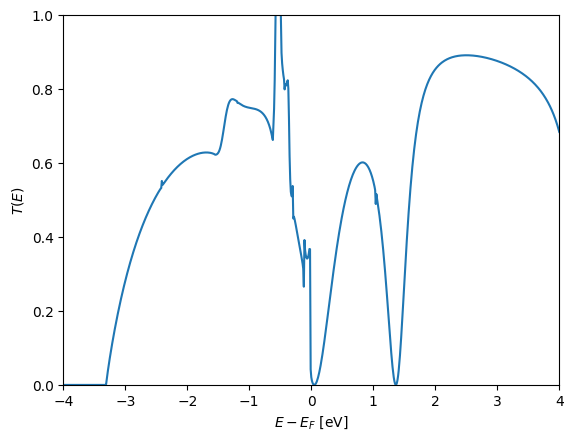

In [10]:
plt.plot(energies, T)
plt.xlim(-4, 4)
plt.ylim(0, 1)
plt.xlabel(r'$E - E_F$ [eV]')
plt.ylabel(r'$T(E)$')

In [11]:
# Example shapes for sanity check
print(se[0].h_ij.shape)
print(se[0].s_ij.shape)


(18, 62)
(18, 62)
